In [2]:
'''
Generate sinusoidal vibration stimuli
Output via sound card a sequence of sinwaves with discrete frequency increment
Created on 2022.11.30 by Yitian Shao (yitian.shao@tu-dresden.de)
'''

# To be commented for still figure format
%matplotlib notebook
%matplotlib notebook

# Import packages
import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as scio
from scipy import signal
import seaborn as sns
import IPython.display as ipd
from IPython.core.display import HTML

''' Figure format'''
plt.rc('font', size=10, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['errorbar.capsize'] = 4

''' Define Color Here '''
pltBlue = (32/255,120/255,180/255)
pltRed = (180/255,32/255,32/255)

''' Suppress warnings '''
import warnings
warnings.filterwarnings('ignore')

''' 
General Settings
'''
AudioFs = 44100 # (Hz) Must match the sampling frequency of the audio output

'''
General Functions
'''
def aPlot(figName='', figsize=(14, 6), is3D=False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize=figsize, dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if (is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def decodeData(fileName, decodeFormat, frontCode='', rearCode='', isString=False):
    segStr = re.findall(frontCode+decodeFormat+rearCode, fileName)
    if segStr:
        decoded = re.findall(decodeFormat, segStr[0])[0]      
        if isString:
            return decoded  
        return float(decoded)
    return None

def lowpassSmooth(datain, cutFreqRatio=0.05, order=8):
    b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def movAvgSmooth(datain, winLen=100):
    dataout = np.convolve(datain, np.ones(winLen)/winLen, mode='same')
    return dataout

def onsetSegmentation(signal, segIntervalSamp, cutFreqRatio=0, thresholdRatio=0.25, disp=False):
    smoothSig = signal
    if(cutFreqRatio > 0):
        smoothSig = lowpassSmooth(abs(signal), cutFreqRatio=cutFreqRatio)
    else:
        smoothSig = movAvgSmooth(abs(signal), winLen=segIntervalSamp)
        
    smoothSig = smoothSig - smoothSig[0]
    
    samp = np.arange(len(signal))
    
    maxValue = np.sqrt(np.mean(np.square(smoothSig)))
    
    segPointInd = np.squeeze(np.argwhere(smoothSig > thresholdRatio * maxValue)) # Find value larger than 25% of peak as valid segment data point
    segGapInd = np.squeeze(np.argwhere(np.diff(segPointInd) > segIntervalSamp))# Index of point where gap is longer than the predetermined interval

    startInd = np.array(segPointInd[segGapInd+1])
    startInd = np.insert(startInd, 0, segPointInd[0])

    endInd = np.array(segPointInd[segGapInd])
    endInd = np.append(endInd, segPointInd[-1])
    
    if disp:
        ax0, _ = aPlot(); 
        ax0.plot(samp, signal, color='tab:grey'); 
        axb = ax0.twinx() 
        axb.plot(samp, smoothSig, color='tab:blue')
        ax0.plot(startInd, np.zeros(startInd.shape), '*r')
        ax0.plot(endInd, np.zeros(endInd.shape), '*c')
        plt.show();
        
    return zip(startInd, endInd)

def sinSignal(sinFreq=250, sinDuration=6.0, Fs=48000, isUnipolar=False, completeCycle=True): # Generate sinusoid signals with percentage range and zero start
    # Sinwave Frequency (Hz), Time duration (sec), Sampling Frequency (Hz), is Unipolar Signal or Bipolar, ensure completed cycle by adjusting time duration
    
    oneCycleDuration = 1.0/sinFreq # (secs) Time duration of one cycle
    
    adjustedDuration = np.ceil(sinDuration/oneCycleDuration)*oneCycleDuration
    
    t = np.arange(int(adjustedDuration * Fs)) / Fs
    
    if (isUnipolar):
        y = -0.5 * np.cos(2 * np.pi * sinFreq * t) + 0.5 # Unipolar: y starts from 0 and increases to 1.0 amplitude
    else:
        y = np.sin(2 * np.pi * sinFreq * t) # Bipolar: y starts from 0 and increases to +1.0, then down to -1.0 amplitude
    
    y = np.insert(y, 0, 0.0)

    return y, t

Time duration of the entire output signal = 34.6 secs


<IPython.core.display.Javascript object>


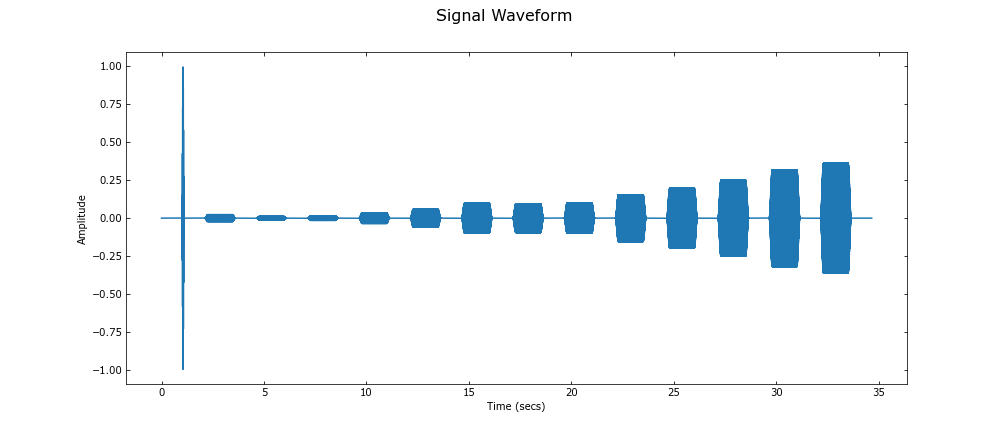

<IPython.core.display.Javascript object>


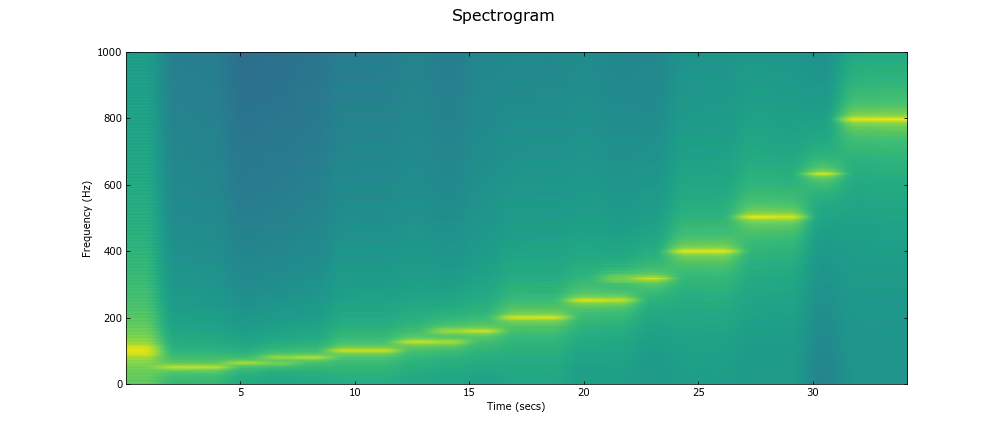

Text(0, 0.5, 'Frequency (Hz)')

In [35]:
segmentTime = 1.5 # (secs) Time duration of each sinwave segment 
segmentInterval = 1.0 # (secs) Time duration of the paused interval between every two sinwaves
amplitudeCap = 1.01 # Cap of the output amplitude to prevent excessively loud sound

# octaveFrequencies = [4.000e-01, 6.000e-01, 1.000e+00, 1.600e+00, 2.000e+00, 2.500e+00, 3.200e+00,
#                      4.000e+00, 5.000e+00, 6.300e+00, 7.900e+00, 1.000e+01, 1.260e+01, 1.580e+01,
#                      2.000e+01, 2.510e+01, 3.160e+01, 3.98e+01, 5.010e+01, 6.310e+01, 7.940e+01,
#                      1.000e+02, 1.259e+02, 1.585e+02, 1.995e+02, 2.512e+02, 3.162e+02, 3.981e+02,
#                      5.012e+02, 6.310e+02, 7.943e+02, 1.000e+03] # 4Hz to 1000Hz (Current voice coil allows no low freq.)

octaveFrequencies = [5.010e+01, 6.310e+01, 7.940e+01,
                     1.000e+02, 1.259e+02, 1.585e+02, 1.995e+02, 2.512e+02, 3.162e+02, 3.981e+02,
                     5.012e+02, 6.310e+02, 7.943e+02] # 50Hz to 794Hz (exclude 1000Hz)

# octaveFrequencies = [5.010e+01, 6.310e+01, 7.940e+01]

# segmentGainSkin= [0.0272, 0.024, 0.028, 0.043,  0.065, 0.092,
#  0.1135, 0.13190819, 0.15739915, 0.19628366, 0.25, 0.32,
#  0.42, 1.  ]

# segmentGain = [0.01101562, 0.00857227, 0.02070403, 0.03490773, 0.05052622, 0.06882767,
#  0.0914225,  0.11949221, 0.15370989, 0.19613606, 0.25,       0.31842742,
#  0.41088783, 0.99724793] # Gain ensure a flat frequency response of the core when bond the shell to the testbed

#segmentGain = [0.034, 0.017, 0.01370403, 0.03, 0.05052622, 0.06882767,
# 0.1,  0.11949221, 0.15370989, 0.19613606, 0.25,       0.31842742,
# 0.41088783, 0.99724793] # Gain ensure a flat frequency response of the core when bond the shell to the testbed

#segmentGain = [0.0235, 0.012, 0.01370403, 0.03, 0.05052622, 0.09882767,
#0.112,  0.11949221, 0.15370989, 0.19613606, 0.25,       0.31842742,
#0.41088783] # Gain ensure a flat frequency response of the core when bond the shell to the testbed (Exclude: 0.99724793)

segmentGain = [0.0235, 0.012, 0.015, 0.035, 0.059, 0.09882767,
0.095,  0.10, 0.15370989, 0.19613606, 0.25,       0.31842742,
0.36088783] # Gain ensure a flat frequency response of the core when bond the shell to the testbed (Exclude: 0.99724793)

pauseSegment = np.zeros(shape=(1,int(AudioFs*segmentInterval)))
outputSignal = pauseSegment

# Insert the starting pulse at the beginning ------------------ begnining pulse
y,_ = sinSignal(sinFreq=100, sinDuration=0.1, Fs=AudioFs)
window = signal.windows.tukey(y.shape[0], alpha=1);
y = np.multiply(y,window)
outputSignal = np.append(outputSignal, y)
outputSignal = np.append(outputSignal, pauseSegment)

# for n in range(2):
for i in range(len(octaveFrequencies)):
    y,_ = sinSignal(sinFreq=octaveFrequencies[i], sinDuration=segmentTime, Fs=AudioFs)

    window = signal.windows.tukey(y.shape[0], alpha=0.2);
    y = np.multiply(y,window)
    y = y * segmentGain[i]

    outputSignal = np.append(outputSignal, y)
    outputSignal = np.append(outputSignal, pauseSegment)
    
# Limit output votlage (sound level) for device safety
outputSignal[outputSignal > amplitudeCap] = amplitudeCap    
outputSignal[outputSignal < -amplitudeCap] = -amplitudeCap    
    
print("Time duration of the entire output signal = %.1f secs" % (outputSignal.shape[0]/AudioFs))  

t = np.arange(outputSignal.shape[0])/AudioFs
ax1,_ = aPlot(figName='Signal Waveform')
ax1.plot(t, outputSignal)
ax1.set_xlabel("Time (secs)")
ax1.set_ylabel("Amplitude")

ax2,_ = aPlot(figName='Spectrogram')
ax2.specgram(outputSignal,Fs=AudioFs, NFFT=65536)
ax2.set_ylim([0, 1000])
ax2.set_xlabel("Time (secs)")
ax2.set_ylabel("Frequency (Hz)")

In [36]:
''' Play the output signal via sound card [Important: Check and ensure the correct amplifier settings!]'''
ipd.Audio(outputSignal,rate=AudioFs)

In [85]:
# y,_ = sinSignal(sinFreq=80, sinDuration=20, Fs=AudioFs) # Play a single frequency     # ipd.Audio(y,rate=AudioFs)

<IPython.core.display.Javascript object>


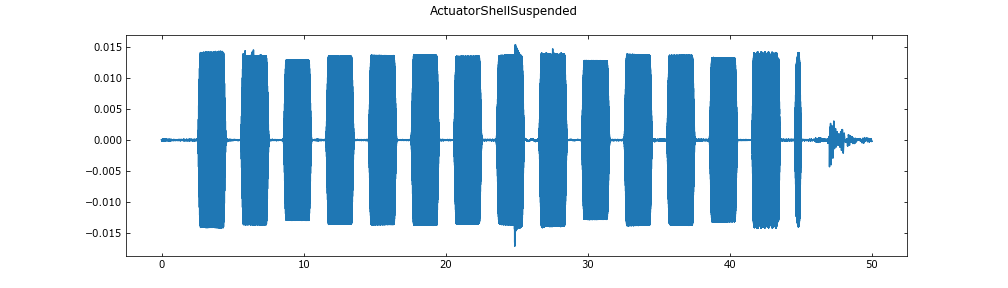

TypeError: onsetSegmentation() got an unexpected keyword argument 'thresholdRatio'

In [22]:
'''
Analysis of Laser Vibrometer Measurement (Added on 2023.01.19)
'''
DataPath = 'D:/IvanData2023.02.28'

# VibroGo data format
VibroGoHeadRowIndex = 3
TimeLabel = '[ s ]'
VibVelocityLabel = '[ m/s ]'

# Settings for data segmentation
segmentLen = segmentTime + segmentInterval # (secs) 
segmentNum = 14 # Number of sweeping frequencies
selectedLen = segmentTime # (secs) Selected the length of the window for analysis

''' Data preprocess and segmentation '''
FSdata = [['Freq', octaveFrequencies]]

for root, directories, files in walk(DataPath):
    for fileName in files:
        dataName = decodeData(fileName, '\w+', frontCode='', rearCode='.txt', isString=True)
        
        metaData = pd.read_csv(ospa.join(root, fileName), header=None, nrows=VibroGoHeadRowIndex, sep='\t')
        display(HTML(metaData.to_html(index=False, header=None)))
        readData = pd.read_csv(ospa.join(root, fileName), header = VibroGoHeadRowIndex, sep='\t')
        
        t = readData[TimeLabel].to_numpy(dtype='float64')
        vibVelocity = readData[VibVelocityLabel].to_numpy(dtype='float64')

        fig,ax = plt.subplots(dpi=72, figsize=(14,4))
        fig.suptitle(dataName)
        ax.plot(t, vibVelocity, color='tab:blue')
        
        ''' Data Segmentation '''
        onsetInd = list(onsetSegmentation(vibVelocity, 4000, cutFreqRatio=0.05, thresholdRatio=0.25, disp=False))[0][0]
        
        selectedStartT = 0 # (secs) ------------ Twick the start time of the window when analyzing a noisy measurement
        t_start = np.arange(selectedStartT+t[onsetInd], t[-1], segmentLen)
        t_start = t_start[:segmentNum]
        t_end = t_start + selectedLen

        freqSweepData = [] 
        for t0, t1 in zip(t_start, t_end):
            ind = (t >= t0) & (t <= t1)
            seg_data = vibVelocity[ind]
            ax.plot(t[ind], seg_data, '-', color='tab:orange')
            
            rmsEn = np.sqrt(np.mean(np.square(seg_data)))
            freqSweepData.append(rmsEn)
            
        FSdata.append([dataName, freqSweepData])
        
FSdata = pd.DataFrame(FSdata, columns = ['Label','SweepData'])
display(FSdata)

In [ ]:
''' Visulize Frequency Response'''
labels = FSdata.Label.unique()

f = np.asarray(FSdata.loc[FSdata['Label'] == 'Freq', 'SweepData'].values[0], dtype='float64')

# dataLabels = ['OnHairySkinLargeActuator02', 'OnHairySkinLargeActuatorRevA02', 'OnHairySkinLargeActuatorRevB02', 
#               'OnHairySkinBottomPlate01', 'OnHairySkinLargeActuatorRevB03', 'OnHairySkinLargeActuatorRevB04','OnHairySkinLargeActuatorRevBY',
# dataLabels = ['OnHairySkinLargeActuatorRevB04','OnHairySkinLargeActuatorRevBY','OnTableRevBLaserOnCore01', 
#               'OnTableRevBLaserOnShell01', 'OnTableBigoneLaserOnShell01']

dataLabels = ['OnHairySkinLargeActuator02', 'OnHairySkinLargeActuatorRevA02', 'OnHairySkinLargeActuatorRevB02', 
              'OnHairySkinBottomPlate01','OnHairySkinBottomPlateFixedWithTape']

labelNum = len(dataLabels)

''' Check data '''
ax,_ = aPlot(figName='Skin Frequency Response (Discrete Sweep)')

for i in range(labelNum):
    mag = np.asarray(FSdata.loc[FSdata['Label'] == dataLabels[i], 'SweepData'].values[0], dtype='float64')
    ax.plot(f, mag, '.-', label=dataLabels[i])
ax.set_xlabel('Frequency (Hz)')
ax.set_xticks(np.arange(50, 1000, 50))
ax.set_ylabel('Magnitude')
ax.legend()



In [ ]:
# ''' Tunning the gain for a flat Frequency Response'''
# labels = FSdata.Label.unique()

# f = np.asarray(FSdata.loc[FSdata['Label'] == 'Freq', 'SweepData'].values[0], dtype='float64')

# ''' Check data '''
# ax,_ = aPlot(figName='Skin Frequency Response (Discrete Sweep)')
# mag = np.asarray(FSdata.loc[FSdata['Label'] == 'OnHairySkinLargeActuator02', 'SweepData'].values[0], dtype='float64')

# magNorm = 1/mag
# magNorm = magNorm/np.max(magNorm)

# # for i in range(f.shape[0]):
# #     print("Freq %.1f Hz - Mag=%.2f " % (f[i], magNorm[i]))

# ax.plot(f, mag, '.-', color='tab:blue')
# axb = ax.twinx()
# axb.plot(f, magNorm, '.-', color='tab:orange')

# ax.set_xlabel('Frequency (Hz)')
# ax.set_ylabel('Magnitude', color='tab:blue')
# axb.set_ylabel('Gain Factor (Normalized)', color='tab:orange')

# print(magNorm)
# print(segmentGain * magNorm)

In [ ]:
# ''' Visulize Frequency Response (202301) '''
# ''' Check data '''
# # mag2 = np.asarray(FSdata.loc[FSdata['Label'] == 'ShuChen202301', 'SweepData'].values[0], dtype='float64')
# # mag3 = np.asarray(FSdata.loc[FSdata['Label'] == 'Yitian202301', 'SweepData'].values[0], dtype='float64')
# # mag4 = np.asarray(FSdata.loc[FSdata['Label'] == 'Maria', 'SweepData'].values[0], dtype='float64')
# # mag5 = np.asarray(FSdata.loc[FSdata['Label'] == 'ShuChen2', 'SweepData'].values[0], dtype='float64')
# # magdB = 20*np.log10(mag/actuatorMag)
# ax.plot(f, mag[1:15], color='tab:blue')
# ax.plot(f, mag2[1:15], color='tab:orange')
# # ax.plot(f, mag3[1:15], color='tab:green')
# # ax.plot(f, mag4[1:15],color='tab:cyan')
# # ax.plot(f, mag5[1:15], '--')